# InstructGoose - 🚧 WORK IN PROGRESS 🚧

> Implementation of Reinforcement Learning from Human Feedback (RLHF) from the InstructGPT paper

Paper: InstructGPT - [Training language models to follow instructions with human feedback](https://arxiv.org/abs/2203.02155)

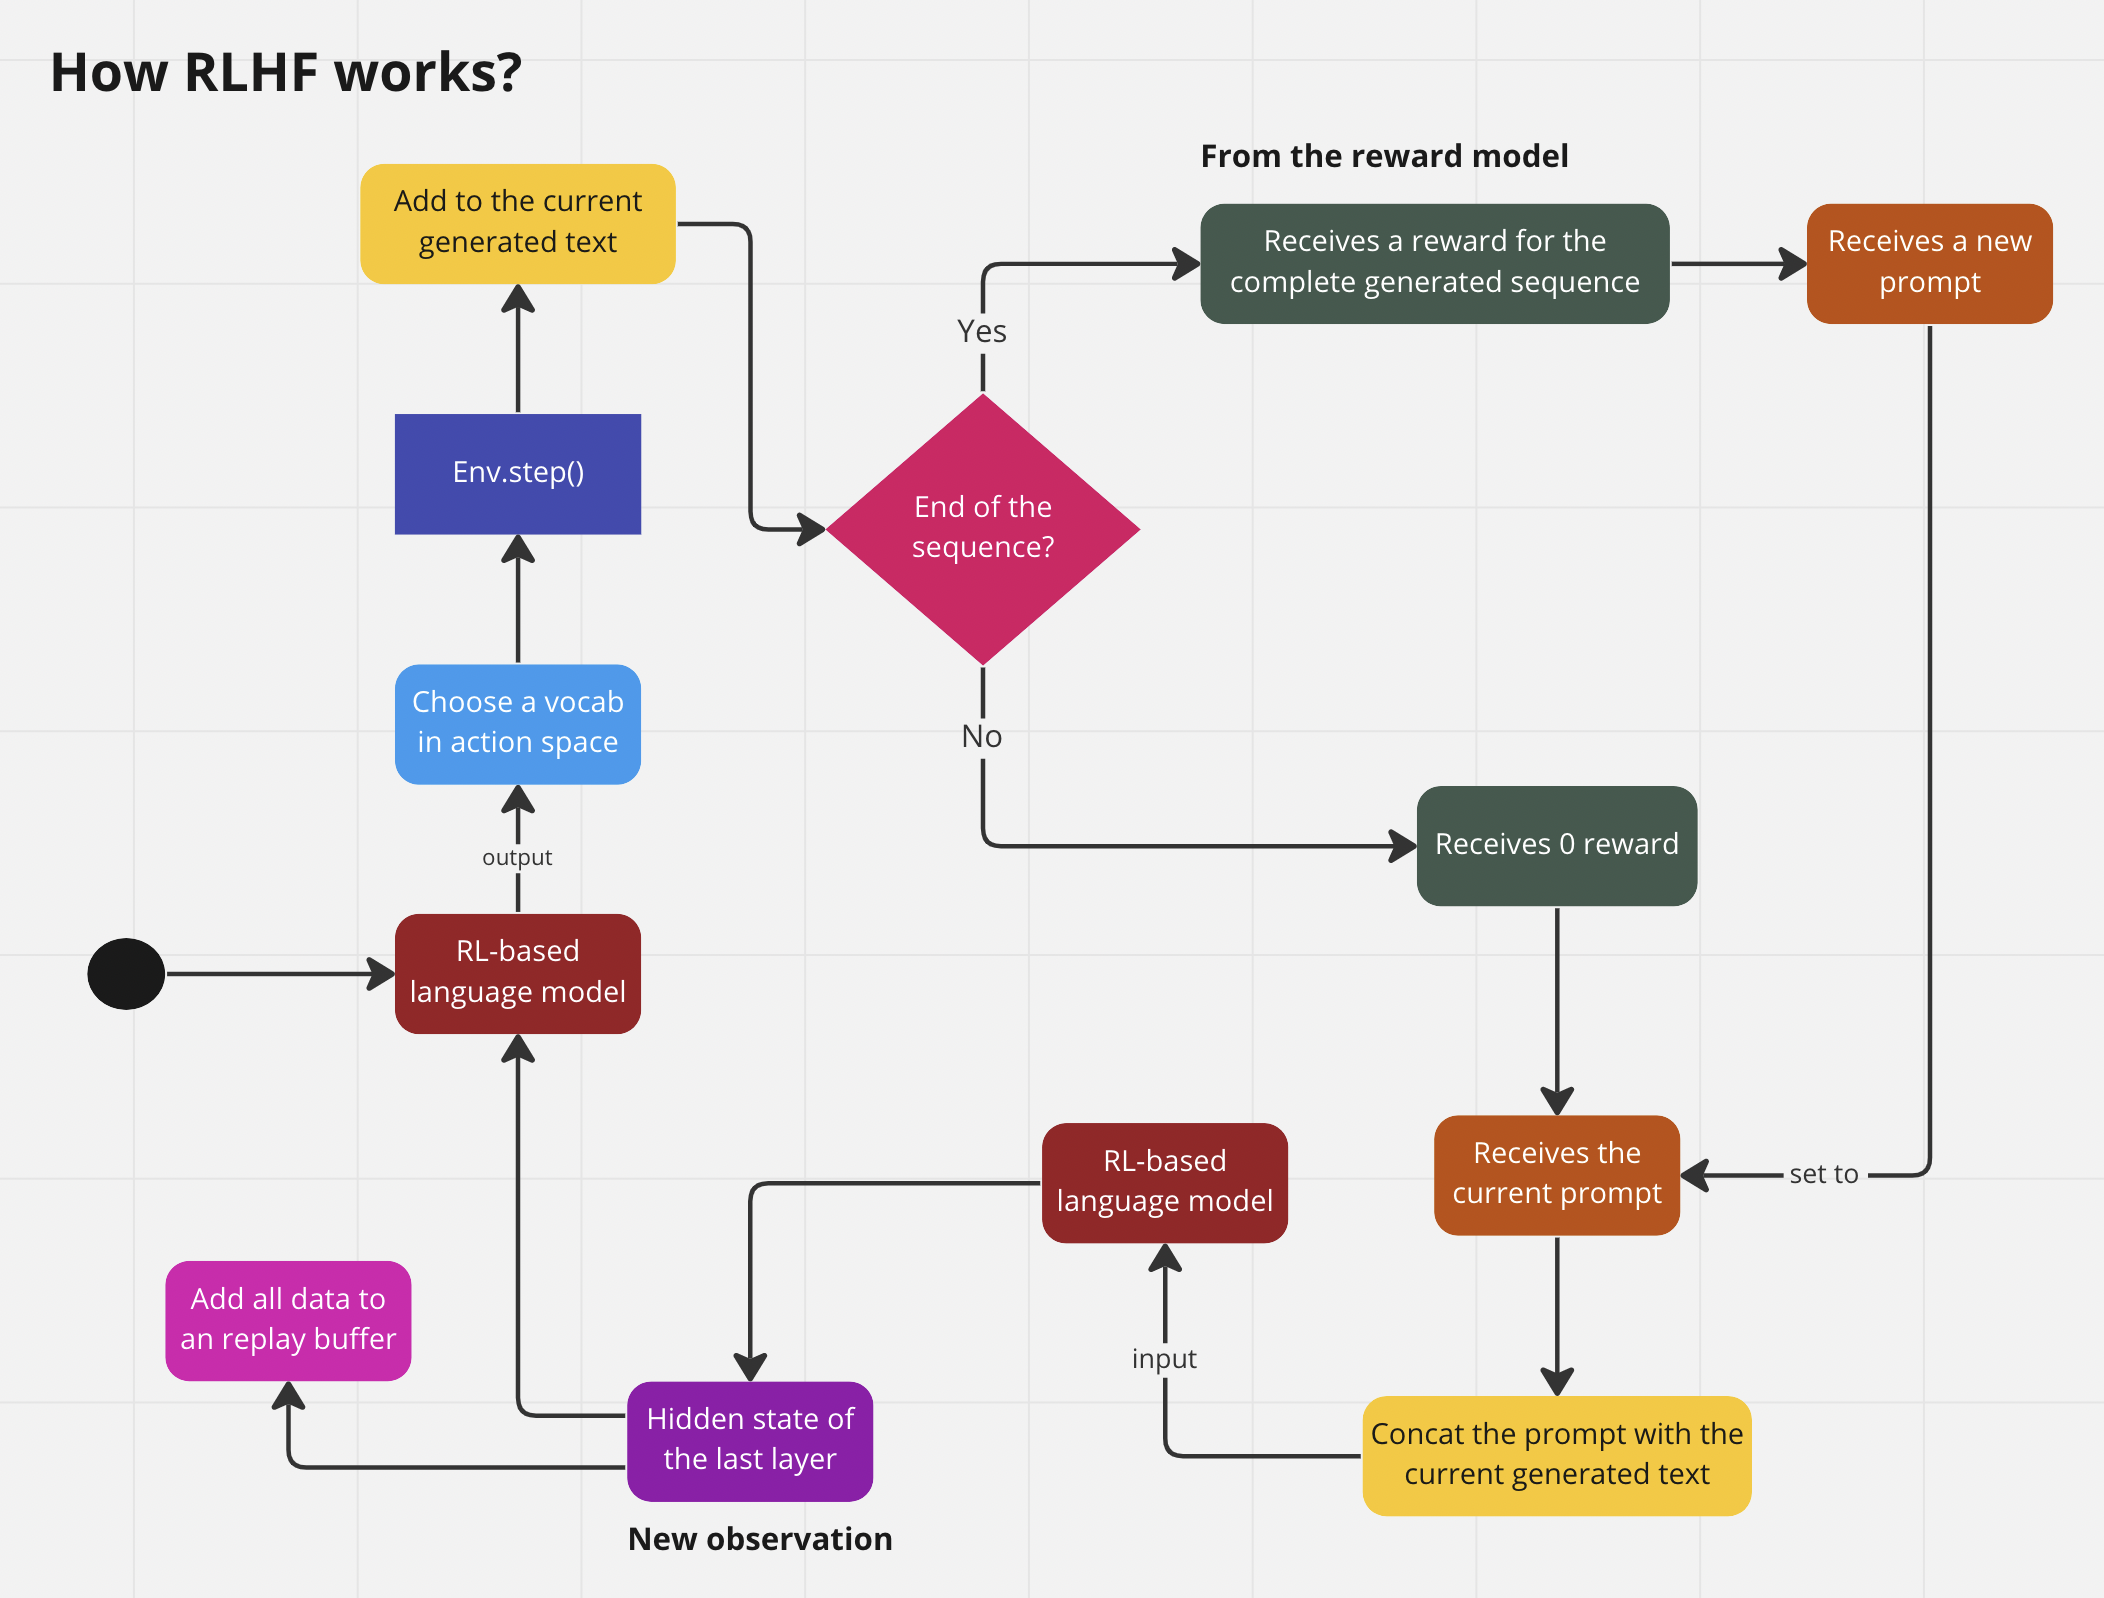

### Questions
- In the context of RLHF, how to calculate the $L_t^{V F}(\theta)$, 
    + Like it's a function of the PPO agent uses to predict how much reward it gets if generates the sequence?
- ~~Does the RL model and the SFT model use the same tokenizer?
    Yes~~
- ~~I don't know how to returns the logit of the generation model~~
- Does the PPO Agent (Language Model) has a value network just like the regular PPO Agent?
- I don't understand how to calculate the advantage in PPO

## Install

```sh
pip install instruct-goose
```

### Train the RL-based language model

```python
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
from torch import optim

from instruct_goose import Agent, RewardModel, RLHFTrainer, RLHFConfig, create_reference_model
```

**Step 1:** Load dataset

```python
dataset = load_dataset("imdb", split="train")
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
```

**Step 2**: Load the pre-trained model and tokenizer

```python
model_base = AutoModelForCausalLM.from_pretrained("gpt2")
reward_model = RewardModel("gpt2")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
eos_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
```

**Step 3**: Create the RL-based language model agent and the reference model

```python
model = Agent(model_base)
ref_model = create_reference_model(model)
```

**Step 4**: Train it

```python
max_new_tokens = 20
generation_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": max_new_tokens
}

config = RLHFConfig()
trainer = RLHFTrainer(model, ref_model, config)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
```

```python
for batch in train_dataloader:
    inputs = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")
    responses = model.generate(
        inputs["input_ids"], attention_mask=inputs["attention_mask"],
        **generation_kwargs
    )
    # extract the generated text
    responses = responses[:, -max_new_tokens:]
    
    with torch.no_grad():
        text_input_ids = torch.stack([torch.concat([q, r]) for q, r in zip(inputs["input_ids"], responses)], dim=0)
        texts = tokenizer.batch_decode(text_input_ids, skip_special_tokens=True)
        # evaluate from the reward model
        rewards = reward_model(texts)
    
    loss = trainer.compute_loss(inputs["input_ids"], responses, rewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"loss={loss}")
```

### TODO

- Add support batch inference for agent
- Add support batch for RLHF trainer

### Resources
I used these resources to implement this

- Copied the `load_yaml` function from https://github.com/Dahoas/reward-modeling
- How to build a dataset to train reward model: https://wandb.ai/carperai/summarize_RLHF/reports/Implementing-RLHF-Learning-to-Summarize-with-trlX--VmlldzozMzAwODM2
- How to add value head in PPO agent: https://github.com/lvwerra/trl
- How to calculate the loss of PPO agent: https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py
- How to use PPO to train RLHF agent: https://github.com/voidful/TextRL
- How PPO works: https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py
- Copied the compute `advantages` and `returns` from `TLR`: https://github.com/lvwerra/trl/blob/d2e8bcf8373726fb92d2110c500f7df6d0bd566d/trl/trainer/ppo_trainer.py#L686